### LightGBM model - To predict the risk of loan applications

**1. Understanding the Dataset**

**Files:**

- `loan.csv`: Contains information about loan applications and statuses.
- `payment.csv`: Contains payment records associated with loans.
- `clarity_underwriting_variables.csv`: Contains additional underwriting variables

In [63]:
loans_csv = "/Users/mogithpn/work/MLE-lightGBM/MLE Assessment/data/loan.csv"
payments_csv = "/Users/mogithpn/work/MLE-lightGBM/MLE Assessment/data/payment.csv"
underwriting_csv = "/Users/mogithpn/work/MLE-lightGBM/MLE Assessment/data/clarity_underwriting_variables.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [38]:
loan_df = pd.read_csv(loans_csv)
payment_df = pd.read_csv(payments_csv)
cuv = pd.read_csv(underwriting_csv, usecols=['underwritingid', 'clearfraudscore'], low_memory=False)

In [39]:
loan_df['loanStatus'].unique()

array(['Withdrawn Application', 'Paid Off Loan', 'Rejected', 'New Loan',
       'Internal Collection', 'CSR Voided New Loan',
       'External Collection', 'Returned Item', 'Customer Voided New Loan',
       'Credit Return Void', 'Pending Paid Off', 'Charged Off Paid Off',
       nan, 'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off',
       'Pending Rescind', 'Customver Voided New Loan',
       'Pending Application', 'Voided New Loan',
       'Pending Application Fee', 'Settlement Pending Paid Off'],
      dtype=object)

#### Check for missing values in loan_df

In [40]:
loan_df.isnull().sum()

loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
hasCF                                    0
dtype: int64

### Distribution of loanstatus


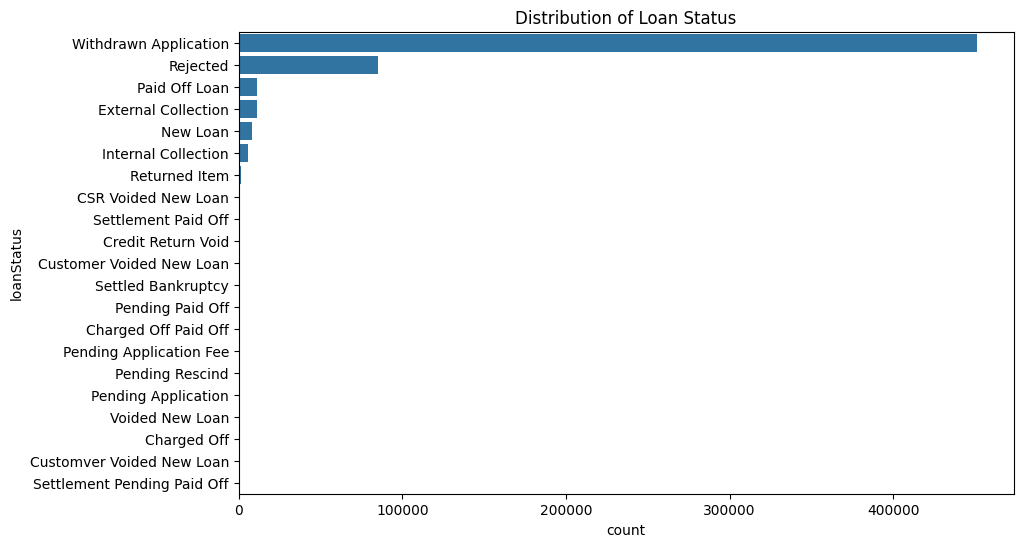

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(y='loanStatus', data=loan_df, order=loan_df['loanStatus'].value_counts().index)
plt.title('Distribution of Loan Status')
plt.show()

### Data cleaning and feature engineering

**Data Preprocessing**

**Target Variable Encoding**

To simplify the problem, we'll categorize the `loanStatus` into two classes:

- **Good**: Loans that are `Paid Off`, `Current`, or in a positive state.
- **Bad**: Loans that are `Charged Off`, `Defaulted`, or in a negative state.

In [42]:
default_statuses = ['Paid Off Loan', 'Settlement Paid Off', 'Pending Paid Off']
non_default_statuses = ['Charged Off', 'Charged Off Paid Off', 'External Collection', 'Internal Collection', 'Settled Bankruptcy']

In [43]:
loan_df['target'] = loan_df['loanStatus'].apply(
    lambda x: 1 if x in default_statuses else 0 if x in non_default_statuses else None
)

In [47]:
#considering all other categories irrelevant
loan_df = loan_df[loan_df['target'].notnull()]
loan_df = loan_df.dropna()

**From `loan_df`:**

- **Repeat Customer**: Use `anon_ssn` and `nPaidOff` to identify if the customer is a repeat borrower.

In [48]:
loan_df['isRepeatCustomer'] = loan_df['nPaidOff'] > 0

Loan Term: Calculate the loan term using originatedDate and applicationDate.

In [53]:
loan_df['applicationDate'] = pd.to_datetime(loan_df['applicationDate'], errors='coerce')
loan_df['originatedDate'] = pd.to_datetime(loan_df['originatedDate'], errors='coerce')
loan_df['loanTermDays'] = (loan_df['originatedDate'] - loan_df['applicationDate']).dt.days
loan_df['loanTermDays'] = loan_df['loanTermDays'].fillna(0) # Fill NaN with 0 for non-originated loans.

In [59]:
loan_df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isRepeatCustomer,loanTermDays
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,1.0,False,0.0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,1.0,True,0.0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,1.0,False,2.0
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,422.64,WI,organic,0,Checked,56621584e4b0100e84141586,1,1.0,True,0.0
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12 18:24:46.356,True,2017-03-12 19:00:23.818,2.0,True,1,...,2875.27,IL,organic,0,Rejected,579101e7e4b0810ad80e43aa,1,0.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577504,LL-I-05352479,c54fe4772636b36b0727b735b85d0254,W,590.0,2015-12-05 16:12:52.557,True,2015-12-06 18:10:30.133,0.0,True,1,...,1806.65,IN,bvMandatory,3,Checked,56630dfee4b0100e8495f049,1,1.0,False,1.0
577505,LL-I-15390953,c81e355845a451b77c29b6515efa2578,B,645.0,2017-01-16 04:56:31.235,True,2017-01-16 05:30:10.885,0.0,True,1,...,5111.56,ND,lead,25,Checked,587c527ce4b08f2487e808ba,1,1.0,False,0.0
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14 19:43:08.685,True,2017-01-14 20:00:10.426,0.0,True,1,...,1042.40,AL,lead,25,Checked,587a7f49e4b08f2485d48358,1,1.0,False,0.0
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22 01:10:50.110,True,2016-06-22 21:46:54.359,0.0,True,1,...,664.12,WI,lead,40,Checked,5769e592e4b0ab6c50364d45,1,1.0,False,0.0


In [67]:
loan_df_merged = pd.merge(loan_df, cuv, left_on='clarityFraudId', right_on='underwritingid', how='left')
loan_df_merged = loan_df_merged.drop(columns=['underwritingid'])
loan_df_merged.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isRepeatCustomer,loanTermDays,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,1.0,False,0.0,879.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,1.0,True,0.0,835.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,1.0,False,2.0,624.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,WI,organic,0,Checked,56621584e4b0100e84141586,1,1.0,True,0.0,770.0
4,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12 18:24:46.356,True,2017-03-12 19:00:23.818,2.0,True,1,...,IL,organic,0,Rejected,579101e7e4b0810ad80e43aa,1,0.0,True,0.0,932.0


**From `payment_df`:**

- **Payment Data with Loan Data**
Important field in payments table including the principal, fees, payment amount and payment status of loans.
Grouping this with loadid, returns aggregate of 

In [75]:
payment_df['paymentDate'] = pd.to_datetime(payment_df['paymentDate'], errors='coerce')

payment_agg = payment_df.groupby('loanId').agg({
    'principal': 'sum',
    'fees': 'sum',
    'paymentAmount': 'sum',
    'paymentStatus': lambda x: (x == 'Rejected').sum(),# Number of failed payments
}).rename(columns={'paymentStatus': 'numFailedPayments'})
payment_agg.head(5)

,principal,fees,paymentAmount,numFailedPayments
loanId,,,,
LL-I-00000021,800.01,1235.21,2035.22,1
LL-I-00000231,1502.47,1896.55,3399.02,2
LL-I-00000238,1265.58,1467.08,2732.66,1
LL-I-00000308,391.72,963.26,1354.98,1
LL-I-00000355,1000.00,1451.52,2451.52,1


In [76]:
# Merge with loan_df merged
loan_df_merged = loan_df_merged.merge(payment_agg, on='loanId', how='left')

In [82]:
loan_df_merged

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,clarityFraudId,hasCF,target,isRepeatCustomer,loanTermDays,clearfraudscore,principal,fees,paymentAmount,numFailedPayments
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,569eb3a3e4b096699f685d64,1,1.0,False,0.0,879.0,3691.28,3395.19,7086.47,0.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,58450a15e4b0bb9d6d7344c7,1,1.0,True,0.0,835.0,2500.00,2147.53,4647.53,0.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,578f9346e4b0810ad5e7b72e,1,1.0,False,2.0,624.0,800.00,1632.08,2432.08,0.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,56621584e4b0100e84141586,1,1.0,True,0.0,770.0,380.18,126.20,506.38,0.0
4,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12 18:24:46.356,True,2017-03-12 19:00:23.818,2.0,True,1,...,579101e7e4b0810ad80e43aa,1,0.0,True,0.0,932.0,1500.00,1375.27,2875.27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24625,LL-I-05352479,c54fe4772636b36b0727b735b85d0254,W,590.0,2015-12-05 16:12:52.557,True,2015-12-06 18:10:30.133,0.0,True,1,...,56630dfee4b0100e8495f049,1,1.0,False,1.0,596.0,600.00,1206.65,1806.65,0.0
24626,LL-I-15390953,c81e355845a451b77c29b6515efa2578,B,645.0,2017-01-16 04:56:31.235,True,2017-01-16 05:30:10.885,0.0,True,1,...,587c527ce4b08f2487e808ba,1,1.0,False,0.0,925.0,2977.89,3977.78,6955.67,0.0
24627,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14 19:43:08.685,True,2017-01-14 20:00:10.426,0.0,True,1,...,587a7f49e4b08f2485d48358,1,1.0,False,0.0,700.0,750.00,753.69,1503.69,0.0
24628,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22 01:10:50.110,True,2016-06-22 21:46:54.359,0.0,True,1,...,5769e592e4b0ab6c50364d45,1,1.0,False,0.0,806.0,400.00,264.12,664.12,0.0


In [81]:
loan_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24630 entries, 0 to 24629
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            24630 non-null  object        
 1   anon_ssn                          24630 non-null  object        
 2   payFrequency                      24630 non-null  object        
 3   apr                               24630 non-null  float64       
 4   applicationDate                   24612 non-null  datetime64[ns]
 5   originated                        24630 non-null  bool          
 6   originatedDate                    24600 non-null  datetime64[ns]
 7   nPaidOff                          24630 non-null  float64       
 8   approved                          24630 non-null  bool          
 9   isFunded                          24630 non-null  int64         
 10  loanStatus                        24630 non-nu

In [83]:
#Drop unwanted columns
loan_df_merged = loan_df_merged.drop(columns=['loanId', 'applicationDate', 'originatedDate', 'loanStatus', 'clarityFraudId','anon_ssn'])

**Handling Categorical Variables**

- **Encoding Categorical Variables**:

In [94]:
categorical_cols = ['payFrequency', 'state', 'leadType', 'fpStatus', 'isRepeatCustomer']

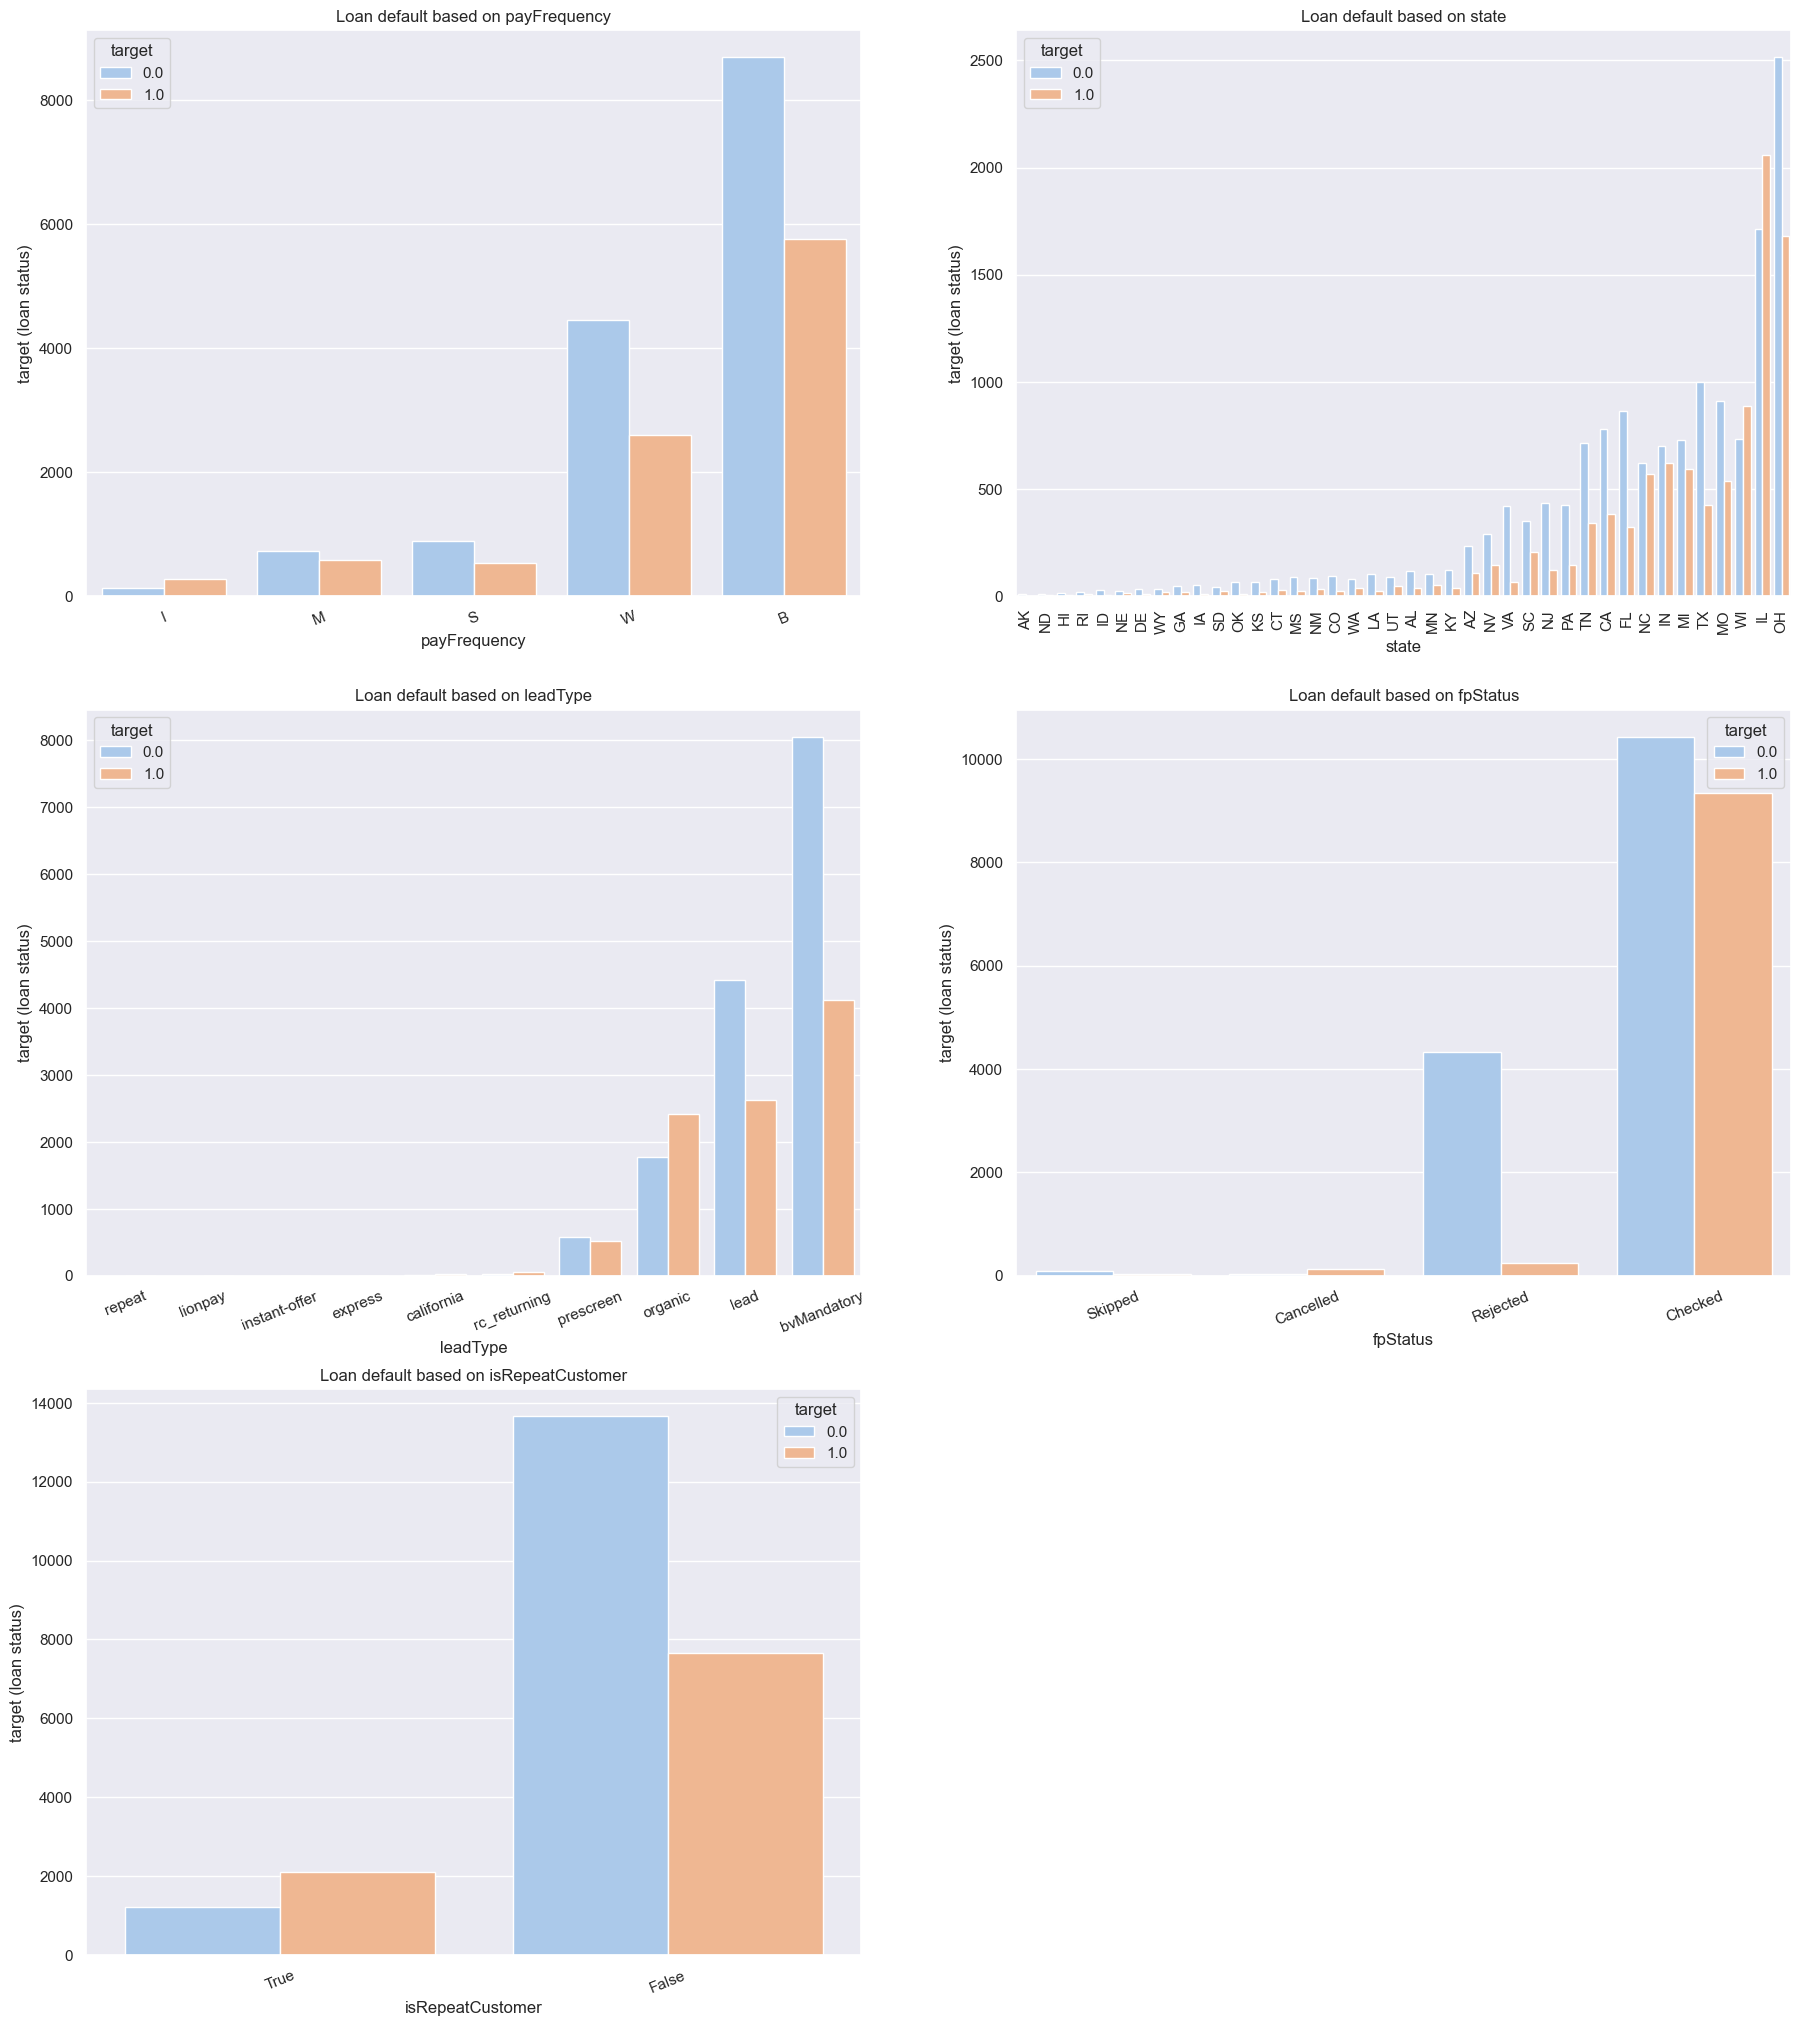

In [93]:
sns.set_theme(style='darkgrid',palette='pastel')

plt.figure(figsize=(22,25))
plt.subplot(321)
sns.countplot(loan_df_merged,x='payFrequency',order=loan_df_merged['payFrequency'].value_counts().index[::-1],hue='target') 
plt.xticks(rotation=22)
plt.xlabel('payFrequency')
plt.ylabel('target (loan status)')
plt.title("Loan default based on payFrequency")

plt.subplot(322)
sns.countplot(loan_df_merged,x='state',order=loan_df_merged['state'].value_counts().index[::-1],hue='target')
plt.xticks(rotation=90)
plt.xlabel('state')
plt.ylabel('target (loan status)')
plt.title("Loan default based on state")

plt.subplot(323)
sns.countplot(loan_df_merged,x='leadType',order=loan_df_merged['leadType'].value_counts().index[::-1],hue='target')
plt.xticks(rotation=22)
plt.xlabel('leadType')
plt.ylabel('target (loan status)')
plt.title("Loan default based on leadType")

plt.subplot(324)
sns.countplot(loan_df_merged,x='fpStatus',order=loan_df_merged['fpStatus'].value_counts().index[::-1],hue='target')
plt.xticks(rotation=22)
plt.xlabel('fpStatus')
plt.ylabel('target (loan status)')
plt.title("Loan default based on fpStatus")

plt.subplot(325)
sns.countplot(loan_df_merged,x='isRepeatCustomer',order=loan_df_merged['isRepeatCustomer'].value_counts().index[::-1],hue='target')
plt.xticks(rotation=22)
plt.xlabel('isRepeatCustomer')
plt.ylabel('target (loan status)')
plt.title("Loan default based on isRepeatCustomer")

plt.show()

In [97]:
# To check all categorical columns are string type
for col in categorical_cols:
    loan_df_merged[col] = loan_df_merged[col].astype(str)

le = LabelEncoder()
for col in categorical_cols:
    loan_df_merged[col] = le.fit_transform(loan_df_merged[col])

In [100]:
loan_df_merged = loan_df_merged.dropna()
loan_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24504 entries, 0 to 24629
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   payFrequency                      24504 non-null  int64  
 1   apr                               24504 non-null  float64
 2   originated                        24504 non-null  bool   
 3   nPaidOff                          24504 non-null  float64
 4   approved                          24504 non-null  bool   
 5   isFunded                          24504 non-null  int64  
 6   loanAmount                        24504 non-null  float64
 7   originallyScheduledPaymentAmount  24504 non-null  float64
 8   state                             24504 non-null  int64  
 9   leadType                          24504 non-null  int64  
 10  leadCost                          24504 non-null  int64  
 11  fpStatus                          24504 non-null  int64  
 12  hasCF    

### Model training 
Splitting the Data

In [101]:
X = loan_df_merged.drop(columns=['target'])
y = loan_df_merged['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

Checking the target variable class imbalance, check if we can follow techniques to prevent the skewed proportion of variable.

In [102]:
print(y_train.value_counts(normalize=True))

target
0.0    0.604011
1.0    0.395989
Name: proportion, dtype: float64


The variables is not significantly skewed, but although it is more than 10%, we can do a trial to see how model performs and tune this hyperparameter.

In [104]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'is_unbalance': True,# Handle imbalance
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Training the model.
lgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
)


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#probabilities prediction
y_pred_prob = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Convert probabilities to binary output with 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9065560391730142
Precision: 0.879045996592845
Recall: 0.885989010989011
AUC-ROC: 0.9639781565562816
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4440
         1.0       0.88      0.89      0.88      2912

    accuracy                           0.91      7352
   macro avg       0.90      0.90      0.90      7352
weighted avg       0.91      0.91      0.91      7352



<Axes: >

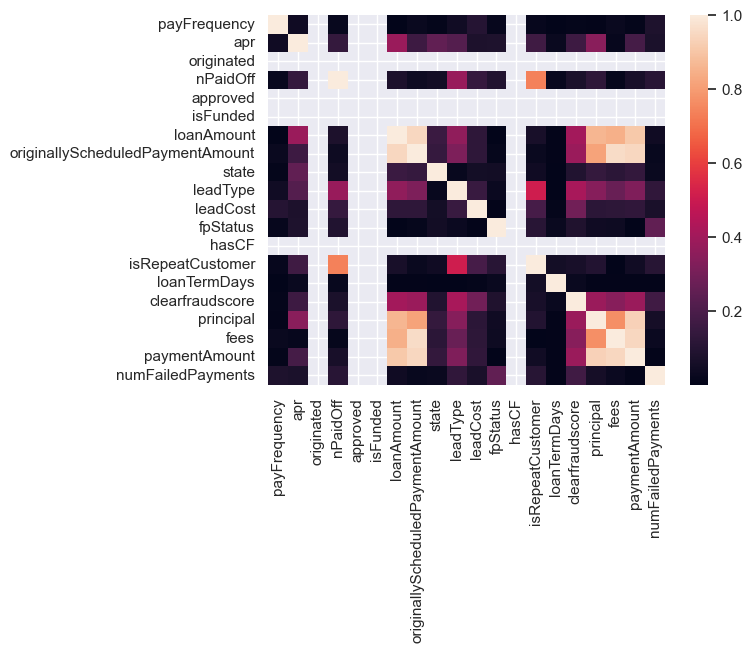

In [127]:
corr_matrix = X_train.corr().abs()
sns.heatmap(corr_matrix)

In [139]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_data_in_leaf': [20, 40, 60],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5],
    'max_depth': [5, 7, 9],
}

gbm = lgb.LGBMClassifier(**params)

grid_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print('Best parameters found by grid search are:', grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found by grid search are: {'num_leaves': 63, 'min_data_in_leaf': 40, 'max_depth': 7, 'learning_rate': 0.1, 'lambda_l2': 0.1, 'lambda_l1': 0.5}


In [148]:
params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'is_unbalance': True,# Handle imbalance
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 7,
    'min_data_in_leaf': 40,
    'min_gain_to_split' : 0.0,
    'lambda_l1': 0.5,
    'lambda_l2': 0.1,
    'seed': 42
}

In [149]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5  # Number of folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [150]:
fold_auc_scores = []
fold = 1

for train_index, val_index in skf.split(X_train, y_train):
    print(f'Fold : {fold}/{n_splits}')

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    train_data = lgb.Dataset(X_tr, label=y_tr)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    lgbm_model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )

    # Predict on val set
    y_pred = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)

    # Eval
    auc = roc_auc_score(y_val, y_pred)
    print(f'AUC for fold {fold}: {auc:.4f}')
    fold_auc_scores.append(auc)

    fold += 1

Fold : 1/5
AUC for fold 1: 0.9609
Fold : 2/5
AUC for fold 2: 0.9591
Fold : 3/5
AUC for fold 3: 0.9656
Fold : 4/5
AUC for fold 4: 0.9605
Fold : 5/5
AUC for fold 5: 0.9628


In [151]:
average_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)
print(f'Average AUC over {n_splits} folds: {average_auc:.4f}')
print(f'Std Dev AUC over {n_splits} folds: {std_auc:.4f}')

Average AUC over 5 folds: 0.9618
Std Dev AUC over 5 folds: 0.0023


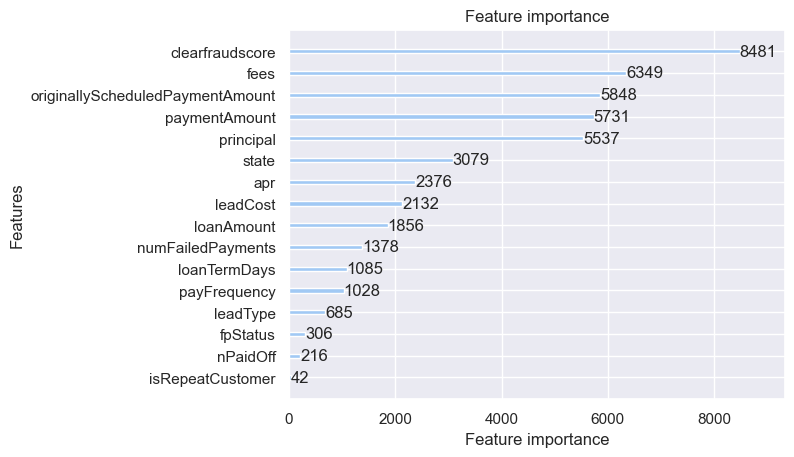

In [152]:
lgb.plot_importance(lgbm_model, max_num_features=20)
plt.show()

In [155]:
y_pred_prob = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Convert probabilities to binary output with 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int)

print("******Results on the test set:************")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))

******Results on the test set:************
Accuracy: 0.8973068552774756
Precision: 0.8761771886989885
Recall: 0.8626373626373627
F1 score: 0.8693545596123897
AUC-ROC: 0.9569763358825858
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      4440
         1.0       0.88      0.86      0.87      2912

    accuracy                           0.90      7352
   macro avg       0.89      0.89      0.89      7352
weighted avg       0.90      0.90      0.90      7352



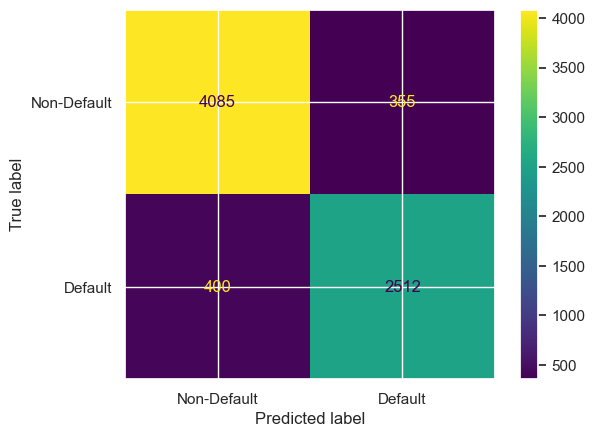

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default', 'Default'])
disp.plot()
plt.show()

**Classification Report Breakdown:**

**Class 0 (Negative Class):**

     Precision: 0.91 (91%)

     Recall: 0.92 (92%)

     F1-Score: 0.92 (92%)

     Support: 4440 instances


**Class 1 (Positive Class):**

     Precision: 0.88 (88%)

     Recall: 0.86 (86%)

     F1-Score: 0.87 (87%)

     Support: 2912 instances


**Overall Metrics:**

     Accuracy: 0.90 (90%)

**Macro Avg:**

     Precision: 0.89 (89%)

     Recall: 0.89 (89%)

     F1-Score: 0.89 (89%)

**Weighted Avg**:

     Precision: 0.90 (90%)

     Recall: 0.90 (90%)

     F1-Score: 0.90 (90%)


In [161]:
lgbm_model.save_model('lgbm_model.txt')